# This notebook contains the functions used to disaggregate the wind speed data received from the ETM model for use in the HWP model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import weibull_min, triang, kstest
import scipy
import itertools
import random
import time
import statistics

In [2]:
# import data from csv

df = pd.read_csv('etmgeg_312.csv',usecols = ['YYYYMMDD','   FG','  FHX','  FHN'])
df = df.rename(columns={'YYYYMMDD': 'date', '   FG': 'mean_day','  FHX': 'hourly_max_day','  FHN': 'hourly_min_day'})
df = df.astype({'date': 'str'})

In [3]:
# subset data of one year

df2019 = df.loc[df['date'].str.startswith('2019')]
df2019 = df2019.reset_index(drop=True)

Text(0.5, 0, 'Wind speed (dm/s)')

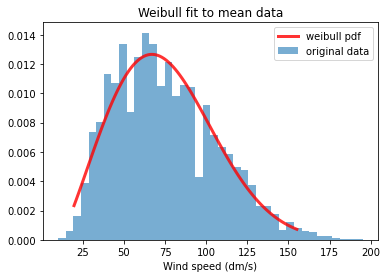

In [5]:
# fit weibull distribution to dataset for further reference

p1,p2,p3 = weibull_min.fit(df['mean_day'].dropna(), floc=10)
weib = weibull_min(p1,p2,p3)

x = np.linspace(weib.ppf(0.01),
                weib.ppf(0.99), 100)

fig, ax = plt.subplots(1, 1)
ax.hist(df['mean_day'], density=True, histtype='stepfilled',bins = 40, alpha=0.6, label='original data')
ax.plot(x, weib.pdf(x), 'r-', lw=3, alpha=0.8, label='weibull pdf')
ax.legend()
ax.set_title('Weibull fit to mean data')
ax.set_xlabel('Wind speed (dm/s)')

In [1]:
# define the basic functions needed for disaggregation and consistency checking

def draw_weibull(N):
    '''
    Draws N values from the previously fitted weibull distribution
    
    Input: N (integer) values to be drawn
    
    Output: List of N float numbers
    '''
    Output = []
    for i in range(N):
        Output.append(round(weib.rvs(),1))
    return Output



def disagg_day_to_hour(N):
    '''
    Draws N values from the draw_weibull function
    
    Input: N (integer) values to be drawn
    
    Output: List of N float numbers
    '''
    
    hour_values = draw_weibull(N)
    return hour_values


def consistency_check_wind(hour_values,mean_wind,max_wind,min_wind,threshold,checktype='set'):
    '''
    Checks the adherence of a disaggregated dataset to key indicators of the original data,
    such as daily mean, max and min values
    
    Input: 
    Hour values: list of disaggregated (float) values
    Mean_wind: mean of original data
    Max_wind: max of original data
    Min_wind: min of original data
    Threshold: allowed obsolute deviation from the mean_wind indicator
    checktype: defines whether input hour value is a single float or a set of 24
    
    Output: True or False (passed or did not pass consistency check)
    '''
    
    mean_ok = True
    max_ok = True
    min_ok = True
    
    
    mean_deviation = abs(np.mean(hour_values) - mean_wind)
    
    if checktype != 'single value':
        if mean_deviation > threshold:
            #print('Mean not appropriate. Deviation of {} exceeds {} threshold'.format(mean_deviation,threshold))
            mean_ok = False
    
    if max(hour_values) > max_wind:
        #print('Max value in disagg ({}) exceeds max value in dataset ({})'.format(max(hour_values), max_wind))
        max_ok = False
    
    if min(hour_values) < min_wind:
        #print('Min value in disagg ({}) exceeds min value in dataset ({})'.format(min(hour_values), min_wind))
        min_ok = False
        
    if mean_ok and max_ok and min_ok:
        #print('consistency check passed')
        return True
    
    else:
        #print('consistency check not passed')
        return False  

In [7]:
def disaggregate_wind_data_baseline(df,threshold_percentage, iteration_max):
    '''
    Disaggregation method for wind data based on the 'baseline' method
    
    Input: 
    df: original (aggregate) data, length must equate to 365
    threshold percentage: float, input for consistency checking. allowed percentual deviation 
                          from mean of disaggregate values per day. e.g. 0.5 implies a 50% allowed deviation
                          
    iteration_max: integer, maximum allowed iterations to create disaggregate data ouput
    
    Output: list of 8760 float values
    '''
    
    attempts = 0
    correct_days = 0
    while attempts < iteration_max and correct_days != 365:
        
        disagg_data = np.repeat(df['mean_day'],24).reset_index(drop=True).tolist()
        
        for i in range(int(len(disagg_data)/24)):
            
            consistency_threshold = threshold_percentage * df['mean_day'][i]
            
            if consistency_check_wind(disagg_data[i*24:(i+1)*24],df['mean_day'][i],df['hourly_max_day'][i],df['hourly_min_day'][i],consistency_threshold,checktype='set') != True:
                print('TROUBLE day {}: mean {}, max {}, min {} (agg source: mean {}, max {}, min {})'.format(i,round(np.mean(disagg_data[i*24:(i+1)*24]),1),\
                        max(disagg_data[i*24:(i+1)*24]),min(disagg_data[i*24:(i+1)*24]),df['mean_day'][i],df['hourly_max_day'][i],df['hourly_min_day'][i]))
                attempts += 1
                correct_days = 0
                continue
                    
            else:
                correct_days += 1
                
        #print('correct days: {}'.format(correct_days))

        if attempts >= iteration_max:
            print('iteration failed after {} attempts'.format(attempts))
            return 0

    return disagg_data



def disaggregate_wind_data_weibull(df,threshold_percentage, iteration_maximum):
    '''
    Disaggregation method for wind data based on the 'weibull' method
    
    Input: 
    threshold percentage: float, input for consistency checking. allowed percentual deviation 
                          from mean of disaggregate values per day. e.g. 0.5 implies a 50% allowed deviation
                          
    iteration_max: integer, maximum allowed iterations to create disaggregate data ouput
    
    Output: list of 8760 float values
    '''
    
    disagg_data = []
    day_count = 0
    for i in range(len(df)):
        day_values = []
        day_values_found = False
        
        consistency_threshold = threshold_percentage * df['mean_day'][i]
        
        
        iteration_max = iteration_maximum
        attempts = 0
        while attempts < iteration_max and day_values_found == False:
            hour_count = 1
            
            
            
            for j in range(24):
                
                value_found = False
                while attempts < iteration_max and value_found == False:
                    #print('Day {}, hour {}, attempt {}'.format(day_count,hour_count, attempts))
                    #print(hour_value, df['hourly_max_day'][i],df['hourly_min_day'][i])
                    attempts += 1
                    hour_value = disagg_day_to_hour(1)
                    
                    if consistency_check_wind(hour_value,df['mean_day'][i],df['hourly_max_day'][i],df['hourly_min_day'][i],consistency_threshold,checktype='single value'):
                        #print('value found ({}), max {}, min {}'.format(hour_value, df['hourly_max_day'][i],df['hourly_min_day'][i]))
                        day_values.append(hour_value[0])
                        value_found = True
                        hour_count += 1
                        attempts = 0
                    
                    else:
                        if len(day_values) > 24:
                            print(day_values)
                    
            if consistency_check_wind(day_values,df['mean_day'][i],df['hourly_max_day'][i],df['hourly_min_day'][i],consistency_threshold,checktype='set'):            
                day_values_found = True
                day_count += 1
            else:
                day_values[:] = []
                #print('TROUBLE day {}: mean {}, max {}, min {} (agg source: mean {}, max {}, min {}). Trying again'.format(day_count,round(np.mean(day_values),1),max(day_values),min(day_values),\
                #                                                                            df['mean_day'][i],df['hourly_max_day'][i],df['hourly_min_day'][i]))
                
                
        disagg_data.append(day_values)
    
        if attempts == iteration_max:
            print('iteration failed after {} attempts'.format(attempts))
            return 0
        
            
        
    
        #else: 
            #print('Day {} iteration succesful. Adding data: mean {}, max {}, min {} (agg source: mean {}, max {}, min {})'.format(day_count,round(np.mean(day_values),1),max(day_values),min(day_values),\
                                                                                            #df['mean_day'][i],df['hourly_max_day'][i],df['hourly_min_day'][i]))
            #print('List length: {}, / 24 = {}'.format(len(sum(disagg_data,[])), len(sum(disagg_data,[])) / 24))
    return sum(disagg_data,[])
    
       

        
def disaggregate_wind_data_triangular(df,threshold_percentage, iteration_maximum):
    '''
    Disaggregation method for wind data based on the 'triangular' method
    
    Input: 
    df: original (aggregate) data, length must equate to 365
    threshold percentage: float, input for consistency checking. allowed percentual deviation 
                          from mean of disaggregate values per day. e.g. 0.5 implies a 50% allowed deviation
                          
    iteration_max: integer, maximum allowed iterations to create disaggregate data ouput
    
    Output: list of 8760 float values
    '''
    
    disagg_data = []
    day_count = 1
    for i in range(len(df)):
        day_values = []
        value_found = False
        
        consistency_threshold = threshold_percentage * df['mean_day'][i]
        
        
        iteration_max = iteration_maximum
        attempts = 0
        while attempts < iteration_max and value_found == False:
            
         
            
            attempts += 1
            
            Min = df['hourly_min_day'][i]
            Max = df['hourly_max_day'][i]
            Mean = df['mean_day'][i]
            
            
            day_values = list(np.random.triangular(Min,Mean,Max,24))
                    
            if consistency_check_wind(day_values,df['mean_day'][i],df['hourly_max_day'][i],df['hourly_min_day'][i],consistency_threshold,checktype='set'):
                #print('value found ({}), max {}, min {}'.format(day_values, df['hourly_max_day'][i],df['hourly_min_day'][i]))
                value_found = True
            #else:
                #print('TROUBLE day {} attempt {}: mean {}, max {}, min {} (agg source: mean {}, max {}, min {})'.format(day_count,attempts,round(np.mean(day_values),1),max(day_values),min(day_values),\
                                                                                            #df['mean_day'][i],df['hourly_max_day'][i],df['hourly_min_day'][i]))
    
        disagg_data.append(day_values)
        
        
        if attempts == iteration_max:
            print('iteration failed after {} attempts'.format(attempts))
            return 0
        #else: 
            #print('Day {} iteration succesful. Adding data: mean {}, max {}, min {} (agg source: mean {}, max {}, min {})'.format(day_count,round(np.mean(day_values),1),max(day_values),min(day_values),\
                                                                                            #df['mean_day'][i],df['hourly_max_day'][i],df['hourly_min_day'][i]))
        
        day_count += 1
    
    return sum(disagg_data,[])
    


def disaggregate_wind_data_rolling_average(df,threshold_percentage, iteration_maximum):
    '''
    Disaggregation method for wind data based on the 'rolling average/uniform' method
    
    Input: 
    df: original (aggregate) data, length must equate to 365
    threshold percentage: float, input for consistency checking. allowed percentual deviation 
                          from mean of disaggregate values per day. e.g. 0.5 implies a 50% allowed deviation
                          
    iteration_max: integer, maximum allowed iterations to create disaggregate data ouput
    
    Output: list of 8760 float values
    '''
    
    def randomize(Mean,Max):
        return  random.uniform(-((Max*10) / (Mean*10)) / 10,((Max*10) / (Mean*10)) / 10)
    
    def disaggregate_wind_data_original(df):
    
        values = [] 
       
        df2 = pd.DataFrame()
        df2['mean'] = np.repeat(df['mean_day'],24)
        df2['max'] = np.repeat(df['hourly_max_day'],24)
        df2 = df2.reset_index(drop=True)
        #print('random = ',randomize(df2['mean'][0],df2['max'][0]))
        values.append(df2['mean'][0] * (1+randomize(df2['mean'][0],df2['max'][0])))
        #print(disagg_data[0], df2['mean'][0])
        
        for i in range(len(df2)):
            if i > 0:
                #print(df2['mean'][i] * (1+randomize(df2['mean'][i],df2['max'][i])),disagg_data[i-1])
                value = (df2['mean'][i] * (1+randomize(df2['mean'][i],df2['max'][i])) + values[i-1]) / 2
                #print(value)
                values.append(max(min(value,df2['max'][i]),0))
    
        return values
    
    
    
    disagg_data = []
    day_count = 1
    for i in range(len(df)):
        day_values = []
        value_found = False
        
        consistency_threshold = threshold_percentage * df['mean_day'][i]
        
        
        iteration_max = iteration_maximum
        attempts = 0
        while attempts < iteration_max and value_found == False:
            
            attempts += 1            
            
            day_values = disaggregate_wind_data_original(df2019.loc[i])
                    
            if consistency_check_wind(day_values,df['mean_day'][i],df['hourly_max_day'][i],df['hourly_min_day'][i],consistency_threshold,checktype='set'):
                #print('value found ({}), max {}, min {}'.format(day_values, df['hourly_max_day'][i],df['hourly_min_day'][i]))
                value_found = True
            #else:
                #print('TROUBLE day {} attempt {}: mean {}, max {}, min {} (agg source: mean {}, max {}, min {})'.format(day_count,attempts,round(np.mean(day_values),1),max(day_values),min(day_values),\
                                                                                            #df['mean_day'][i],df['hourly_max_day'][i],df['hourly_min_day'][i]))
    
        disagg_data.append(day_values)
        
        
        if attempts == iteration_max:
            print('iteration failed after {} attempts'.format(attempts))
            return 0
        #else: 
            #print('Day {} iteration succesful. Adding data: mean {}, max {}, min {} (agg source: mean {}, max {}, min {})'.format(day_count,round(np.mean(day_values),1),max(day_values),min(day_values),\
                                                                                            #df['mean_day'][i],df['hourly_max_day'][i],df['hourly_min_day'][i]))
        
        day_count += 1
    
    return sum(disagg_data,[])

def aggregate_data(data):
    '''
    Aggregation method to convert disaggregated (hour) values back to original time resolution (days)
    
    Input:
    data: list of 8760 float values
    
    Output:
    list of 365 float values
    
    '''
    new_mean = []
    day_values= np.array_split(data, len(data)/24)
    #print(data)
    for i in range(len(day_values)):
        #print(len(day_values),i,day_values[i])
        new_mean.append(statistics.mean(day_values[i]))
    
    return new_mean

In [2]:
def thrashing_test(df,disagg_type,thrash_iterations,disagg_threshold_percentage,disagg_iteration_maximum,plot=False):
    '''
    Thrashing test. Repeatedly disaggregates and aggregates a dataset and displays the resulting effects
    
    Input:
    df: original (aggregate) data, length must equate to 365
    disagg_type: string, specifies which disaggregation method is used
    thrash_iterations: integer, specifies the amount of subsequent disaggregations and aggregations
    disagg_threshold_percentage: float, input for consistency checking. allowed percentual deviation from mean 
                                 of disaggregate values per day. e.g. 0.5 implies a 50% allowed deviation
                             
    disagg_iteration_maximum: integer, maximum allowed iterations to create disaggregate data ouput
    Plot: Boolean (True/False), choice to display graphs from results
    Output: list of float values of the change in the first value of the data throughout thrashing
    
    '''
    start = time.time()
    df_iteration = df.copy()
    first_value_progression = []
    first_value_progression.append(df2019['mean_day'][0])
    
    print('Commencing {} thrashing test with {} iterations'.format(disagg_type,thrash_iterations))
    
    for i in range(thrash_iterations):
        disagg = globals()['disaggregate_wind_data_' + disagg_type.replace(' ','_')](df_iteration,disagg_threshold_percentage,disagg_iteration_maximum)
        if disagg == 0:
            print('thrashing test failed. Unable to iterate succesfully to stated threshold')
            return 0
        agg = aggregate_data(disagg)
        df_iteration['mean_day'] = agg
        max_surpass_check = len(df_iteration.loc[df_iteration['mean_day'] > df_iteration['hourly_max_day']]) 
        min_surpass_check = len(df_iteration.loc[df_iteration['mean_day'] < df_iteration['hourly_min_day']]) 
        
        if max_surpass_check or min_surpass_check:
            print('mean drifted beyond original max or min value. Thrashing failed')
            return 0
        
        first_value_progression.append(round(agg[0],3))
        #print('round {} complete, {}'.format(i,round(agg[0],3)))
    
    end = time.time()
    df_iteration['drift'] = abs(df_iteration['mean_day']-df['mean_day'])
    
    print('Thrashing test took {} seconds, {} seconds per A/D round'.format(round(end - start,3),round((end-start)/thrash_iterations,3))) 
    
    Mean = round(statistics.mean(first_value_progression),3)
    Mean_percent = round((Mean / df_iteration['mean_day'][0] - 1) * 100,2)
    Max = round(max(first_value_progression),3)
    Max_percent = round((Max / df_iteration['mean_day'][0] - 1) * 100,2)
    Min = round(min(first_value_progression),3)
    Min_percent = round((Min / df_iteration['mean_day'][0] - 1) * 100,2)
    
    print('Mean of drift {} ({}%), upper bound {} ({}%), lower bound {} ({}%)\n'\
          .format(Mean,Mean_percent,Max,Max_percent,Min,Min_percent))
    
    if plot == True:
        plt.plot(first_value_progression,label = 'thrashed value')
        plt.hlines(y = first_value_progression[0], xmin = 0, xmax = len(first_value_progression),color = 'red',label='original value')
        plt.hlines(y = Mean, xmin = 0, xmax = len(first_value_progression),\
                   color = 'green',label='thrashed value mean',alpha = 0.8,linestyle=':')
        plt.title('Change in one day-value during {} thrashing'.format(disagg_type))
        plt.ylabel('Wind speed (dm/s)')
        plt.xlabel('Performed A/D iterations')
        plt.legend(loc = 'upper right')
        plt.show()
    print('\n\n')
    
    
    return first_value_progression

In [3]:
def plot_against_pdf(disagg_values,disagg_type):
    '''
    Plots disaggregated data against orignal weibull distribution and performs a 
    Kolmogorov-Smirnov test to compare the disaggregated data to the distribution
    
    Input:
    disagg_values: list of 8760 floats
    disagg_type: string, specifies which disaggregation method is used
    '''
    
    plt.hist(disagg_values,bins=40,density=True,alpha=0.6, label = '{}-based disagg'.format(disagg_type))
    plt.plot(x, weib.pdf(x), 'r-', lw=3, alpha=0.8, label='weibull pdf')
    
    kolmogorov_smirnov = kstest(rvs=disagg_values,cdf=weib.cdf)
    print(kolmogorov_smirnov)
    p_value = kolmogorov_smirnov[1]
    
    
    plt.title('{}-based disaggregation, p = {}'.format(disagg_type.capitalize(),f'{p_value:.3f}'))
    plt.xlabel('Wind speed (dm/s)')
    plt.legend()
    plt.show()
    

def plot_sample_of_disagg(disagg_values,disagg_type):
    '''
    Plots a sample of disaggregated data. Adds mean, max and min of original data for reference
    
    Input:
    disagg_values: list of 8760 floats
    disagg_type: string, specifies which disaggregation method is used
    '''
    
    dfagg = pd.DataFrame()
    dfagg['mean'] = np.repeat(df2019['mean_day'],24)
    dfagg['max'] = np.repeat(df2019['hourly_max_day'],24)
    dfagg['min'] = np.repeat(df2019['hourly_min_day'],24)
    dfagg = dfagg.reset_index(drop=True)
    plt.figure(figsize=(15, 5))
    plt.plot(disagg_values[:24*7],label = '{} disagg'.format(disagg_type))
    plt.plot(dfagg['mean'][:24*7],label = 'original agg mean',alpha = 0.7)
    plt.plot(dfagg['max'][:24*7],label = 'original agg max',alpha = 0.8,linestyle=':')
    plt.plot(dfagg['min'][:24*7],label = 'original agg min',alpha = 0.8,linestyle=':')
    plt.title('{} disagg sample'.format(disagg_type.capitalize()))
    plt.ylabel('Wind speed (dm/s)')
    plt.xlabel('Time (hours)')
    plt.legend(loc = 'lower left')
    plt.show()

In [9]:
# create disaggregate data from baseline method
disagg_values_baseline = disaggregate_wind_data_baseline(df2019,0,1)

In [10]:
# create disaggregate data from rolling average/uniform method
HWP_original = disaggregate_wind_data_rolling_average(df2019,0.005,100)

In [11]:
# create disaggregate data from weibull method
disagg_values_weibull = disaggregate_wind_data_weibull(df2019,0.55, 20000)

In [12]:
# create disaggregate data from triangular method
disagg_values_triangular = disaggregate_wind_data_triangular(df2019,0.025,200000)

KstestResult(statistic=0.06710805721704594, pvalue=9.587963480696942e-35)


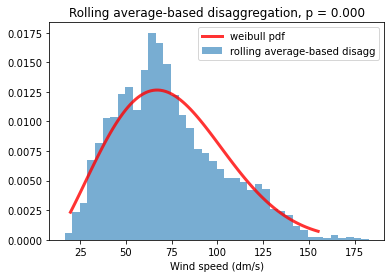

KstestResult(statistic=0.06609042093827011, pvalue=1.0360874054513445e-33)


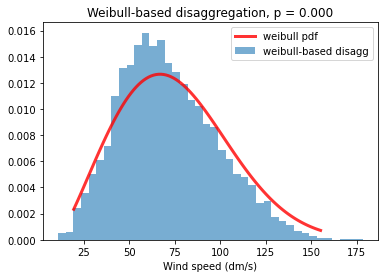

KstestResult(statistic=0.049918444904547554, pvalue=2.072237003325239e-19)


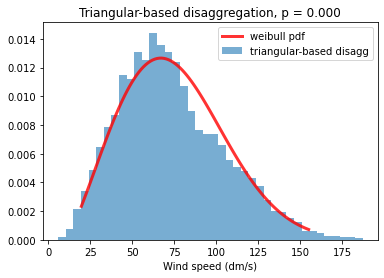

In [14]:
# compare individual disaggregates to pdf of original data

plot_against_pdf(HWP_original,'rolling average')
plot_against_pdf(disagg_values_weibull, 'weibull')
plot_against_pdf(disagg_values_triangular, 'triangular')

Text(0.5, 0, 'Wind speed (dm/s)')

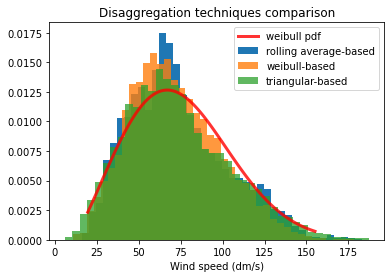

In [15]:
# compare disaggregates to pdf of original data

plt.hist(HWP_original,bins=40,density=True,alpha=1, label = 'rolling average-based')
plt.hist(disagg_values_weibull,bins=40,density=True,alpha=0.8, label = 'weibull-based')
plt.hist(disagg_values_triangular,bins=40,density=True,alpha=0.75, label = 'triangular-based')

plt.plot(x, weib.pdf(x), 'r-', lw=3, alpha=0.8, label='weibull pdf')
plt.legend()
plt.title('Disaggregation techniques comparison')
plt.xlabel('Wind speed (dm/s)')

Commencing baseline thrashing test with 100 iterations
Thrashing test took 3.995 seconds, 0.04 seconds per A/D round
Mean of drift 94.0 (0.0%), upper bound 94.0 (0.0%), lower bound 94.0 (0.0%)



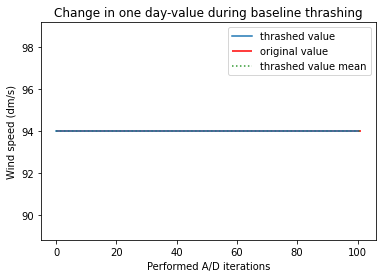




Commencing rolling average thrashing test with 100 iterations
Thrashing test took 99.643 seconds, 0.996 seconds per A/D round
Mean of drift 93.803 (2.02%), upper bound 96.564 (5.02%), lower bound 90.154 (-1.95%)



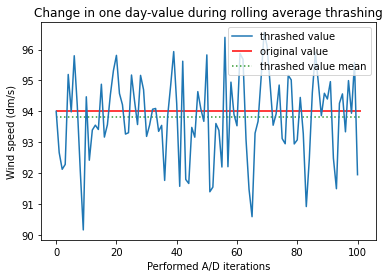




Commencing weibull thrashing test with 100 iterations
Thrashing test took 289.692 seconds, 2.897 seconds per A/D round
Mean of drift 92.843 (6.79%), upper bound 101.238 (16.45%), lower bound 85.921 (-1.17%)



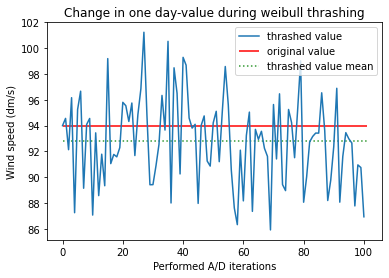




Commencing triangular thrashing test with 100 iterations
Thrashing test took 8.187 seconds, 0.082 seconds per A/D round
Mean of drift 99.489 (0.95%), upper bound 106.163 (7.72%), lower bound 93.104 (-5.53%)



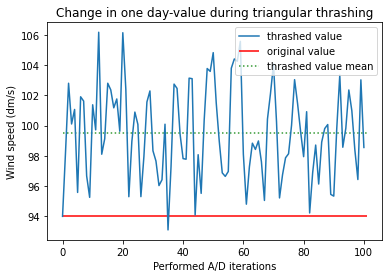

In [16]:
# perform thrashing tests on each disaggregation method and display progression of the first value

test_baseline = thrashing_test(df2019,'baseline',100,0,10000,plot=True)
test_rolling_average = thrashing_test(df2019,'rolling average',100,0.05,10000,plot=True)
test_weibull = thrashing_test(df2019,'weibull',100,0.55,10000,plot=True)
test_triangular = thrashing_test(df2019,'triangular',100,0.5,10000,plot=True)

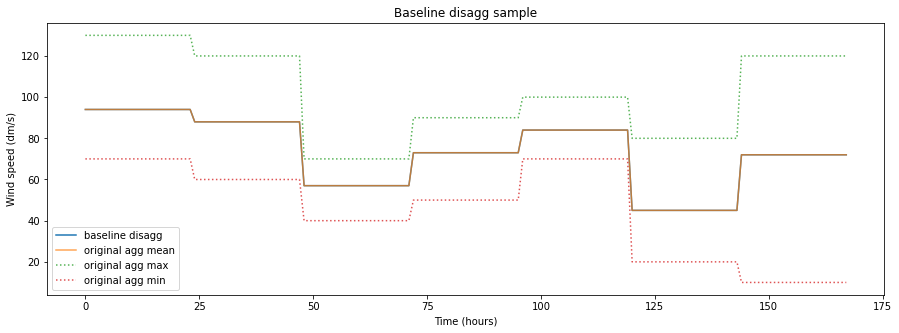

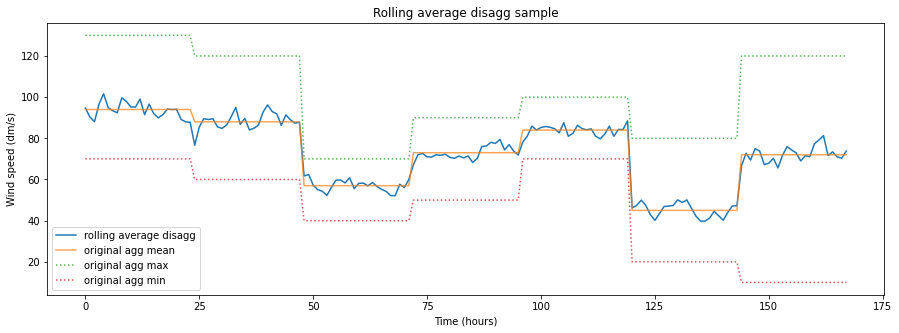

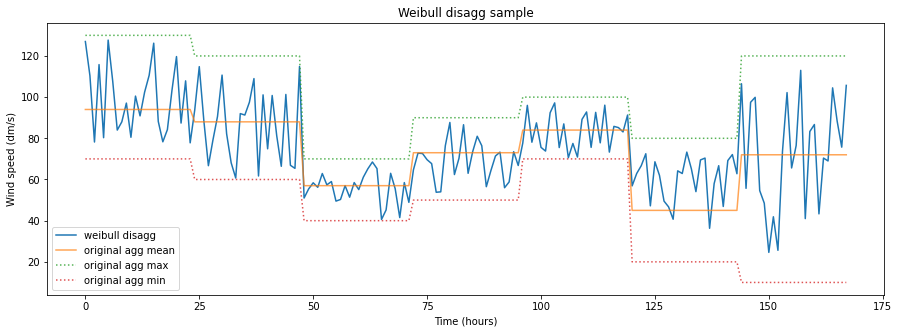

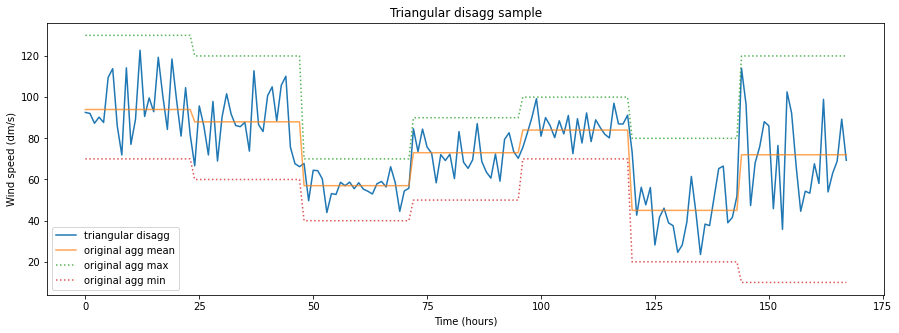

In [17]:
# plot sample of disaggregated data from each disaggregate

plot_sample_of_disagg(disagg_values_baseline,'baseline')
plot_sample_of_disagg(HWP_original,'rolling average')
plot_sample_of_disagg(disagg_values_weibull, 'weibull')
plot_sample_of_disagg(disagg_values_triangular, 'triangular')

In [18]:
# export wind data for conversion to power (input of HWP)
# conversion to HWP input in AD_prep_for_input.ipynb

#Dict = {'baseline':disagg_values_baseline,'rolling_average':HWP_original,'triangular':disagg_values_triangular,'weibull':disagg_values_weibull}
#df_csv = pd.DataFrame(Dict)
#df_csv.to_csv('wind_disagg2.csv',index=False)